##### Copyright 2019 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# CycleGAN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/cyclegan"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/cyclegan.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/cyclegan.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/cyclegan.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This notebook demonstrates unpaired image to image translation using conditional GAN's, as described in [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/abs/1703.10593), also known as CycleGAN. The paper proposes a method that can capture the characteristics of one image domain and figure out how these characteristics could be translated into another image domain, all in the absence of any paired training examples. 

This notebook assumes you are familiar with Pix2Pix, which you can learn about in the [Pix2Pix tutorial](https://www.tensorflow.org/tutorials/generative/pix2pix). The code for CycleGAN is similar, the main difference is an additional loss function, and the use of unpaired training data.

CycleGAN uses a cycle consistency loss to enable training without the need for paired data. In other words, it can translate from one domain to another without a one-to-one mapping between the source and target domain. 

This opens up the possibility to do a lot of interesting tasks like photo-enhancement, image colorization, style transfer, etc. All you need is the source and the target dataset (which is simply a directory of images).

![Output Image 1](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/horse2zebra_1.png?raw=1)
![Output Image 2](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/horse2zebra_2.png?raw=1)

## Set up the input pipeline

Install the [tensorflow_examples](https://github.com/tensorflow/examples) package that enables importing of the generator and the discriminator.

In [2]:
# !pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-b1kssxem
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-b1kssxem
  Created wheel for tensorflow-examples: filename=tensorflow_examples-36c0ad2f20ca4092210cadedb6da92603fee2ff5_-cp36-none-any.whl size=131220 sha256=1f594cff2096e38a85a134216381e5ec083286700073fb034d7da4d560858c0a
  Stored in directory: /tmp/pip-ephem-wheel-cache-nj75te3y/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


In [0]:
import tensorflow as tf

In [0]:
import tensorflow_datasets as tfds

import os
import time
import datetime
import matplotlib.pyplot as plt
from IPython.display import clear_output

tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Input Pipeline

This tutorial trains a model to translate from images of horses, to images of zebras. You can find this dataset and similar ones [here](https://www.tensorflow.org/datasets/datasets#cycle_gan). 

As mentioned in the [paper](https://arxiv.org/abs/1703.10593), apply random jittering and mirroring to the training dataset. These are some of the image augmentation techniques that avoids overfitting.

This is similar to what was done in [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#load_the_dataset)

* In random jittering, the image is resized to `286 x 286` and then randomly cropped to `256 x 256`.
* In random mirroring, the image is randomly flipped horizontally i.e left to right.

In [5]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

dir_project = '/content/drive/My Drive/CS231N Spring 2020 Project'
dir_data = os.path.join(dir_project, 'sketchy_dataset')
dir_results = os.path.join(dir_project, 'results')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
# if working on Google Cloud

# from google.colab import auth
# auth.authenticate_user()

# project_id = 'cs231n-277418'
# !gcloud config set project {project_id}
# !gsutil ls

# dir_project = '/CS231N Spring 2020 Project'
# dir_data = os.path.join(dir_project, 'sketchy_dataset')
# dir_results = os.path.join(dir_project, 'results')


KeyboardInterrupt: ignored

In [0]:
# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
FOLDERNAME = 'CS231N Spring 2020 Project'
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

In [0]:
import pix2pix

In [0]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [0]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [0]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [0]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  # image = tf.image.resize(image, [286, 286],
  #                         method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [0]:
# Reads an image from a file & decodes it into a dense tensor
def parse_image(filename):
  parts = tf.strings.split(filename, os.sep)
  category = parts[-4]
  label = parts[-2]
  image = tf.io.read_file(filename)
  if tf.math.equal(tf.constant('sketch'), category):
      image = tf.io.decode_png(image)
  else:
      image = tf.io.decode_jpeg(image)
  return image

In [0]:
def preprocess_image_train(image):
  image = parse_image(image)
  # image = random_jitter(image)
  image = normalize(image)
  return image

In [0]:
def preprocess_image_test(image):
  image = parse_image(image)
  image = normalize(image)
  return image

In [0]:
PATH_A = os.path.join(dir_data, 'photo', 'tx_000100000000', 'airplane')
PATH_B = os.path.join(dir_data, 'sketch', 'tx_000100000000', 'airplane')
PATH_TEST_A = os.path.join(dir_data, 'photo', 'tx_000000000000', 'airplane')
PATH_TEST_B = os.path.join(dir_data, 'sketch', 'tx_000000000000', 'airplane')

In [0]:
train_datasetA = tf.data.Dataset.list_files(os.path.join(PATH_A, '*.*'))
train_datasetB = tf.data.Dataset.list_files(os.path.join(PATH_B, '*.*'))
test_datasetA = tf.data.Dataset.list_files(os.path.join(PATH_TEST_A, '*.*'))
test_datasetA = test_datasetA.take(100)
test_datasetB = tf.data.Dataset.list_files(os.path.join(PATH_TEST_B, '*.*'))
test_datasetB = test_datasetB.take(100)

train_datasetA = train_datasetA.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

train_datasetB = train_datasetB.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_datasetA = test_datasetA.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_datasetB = test_datasetB.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

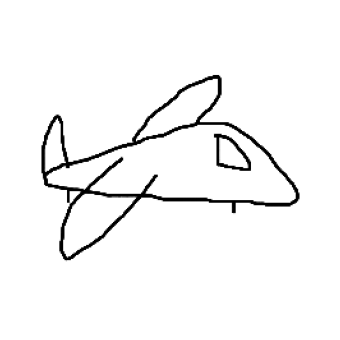

In [18]:
plt.figure(figsize=(6, 6))
image = parse_image(os.path.join(dir_data, 'sketch', 'tx_000100000000', 'airplane', 'n02691156_6120-3.png'))
image = normalize(image)
plt.imshow(image * 0.5 + 0.5)
plt.axis('off')
plt.show()

In [19]:
dummy = tf.data.Dataset.list_files(os.path.join(PATH_A, '*.*'))
for f in dummy.take(5):
  print(f.numpy())


b'/content/drive/My Drive/CS231N Spring 2020 Project/sketchy_dataset/photo/tx_000100000000/airplane/n02691156_10718.jpg'
b'/content/drive/My Drive/CS231N Spring 2020 Project/sketchy_dataset/photo/tx_000100000000/airplane/n02691156_1074.jpg'
b'/content/drive/My Drive/CS231N Spring 2020 Project/sketchy_dataset/photo/tx_000100000000/airplane/n02691156_2196.jpg'
b'/content/drive/My Drive/CS231N Spring 2020 Project/sketchy_dataset/photo/tx_000100000000/airplane/n02691156_1512.jpg'
b'/content/drive/My Drive/CS231N Spring 2020 Project/sketchy_dataset/photo/tx_000100000000/airplane/n02691156_1692.jpg'


In [0]:
sample_photo = next(iter(train_datasetA))
sample_sketch = next(iter(train_datasetB))

## Import and reuse the Pix2Pix models

Import the generator and the discriminator used in [Pix2Pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) via the installed [tensorflow_examples](https://github.com/tensorflow/examples) package.

The model architecture used in this tutorial is very similar to what was used in [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py). Some of the differences are:

* Cyclegan uses [instance normalization](https://arxiv.org/abs/1607.08022) instead of [batch normalization](https://arxiv.org/abs/1502.03167).
* The [CycleGAN paper](https://arxiv.org/abs/1703.10593) uses a modified `resnet` based generator. This tutorial is using a modified `unet` generator for simplicity.

There are 2 generators (G and F) and 2 discriminators (X and Y) being trained here. 

* Generator `G` learns to transform image `X` to image `Y`. $(G: X -> Y)$
* Generator `F` learns to transform image `Y` to image `X`. $(F: Y -> X)$
* Discriminator `D_X` learns to differentiate between image `X` and generated image `X` (`F(Y)`).
* Discriminator `D_Y` learns to differentiate between image `Y` and generated image `Y` (`G(X)`).

![Cyclegan model](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cyclegan_model.png?raw=1)

In [0]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


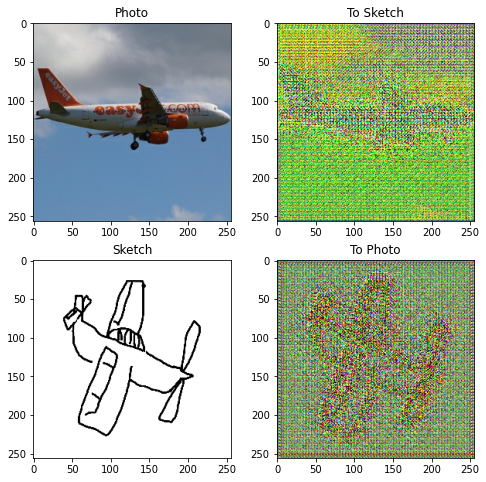

In [22]:
to_sketch = generator_g(sample_photo)
to_photo = generator_f(sample_sketch)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_photo, to_sketch, sample_sketch, to_photo]
title = ['Photo', 'To Sketch', 'Sketch', 'To Photo']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

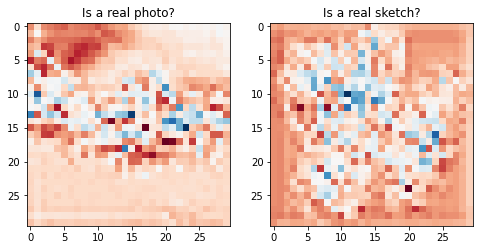

In [23]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real photo?')
plt.imshow(discriminator_y(sample_photo)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real sketch?')
plt.imshow(discriminator_x(sample_sketch)[0, ..., -1], cmap='RdBu_r')

plt.show()

## Loss functions

In CycleGAN, there is no paired data to train on, hence there is no guarantee that the input `x` and the target `y` pair are meaningful during training. Thus in order to enforce that the network learns the correct mapping, the authors propose the cycle consistency loss.

The discriminator loss and the generator loss are similar to the ones used in [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#define_the_loss_functions_and_the_optimizer).

In [0]:
LAMBDA = 10

In [0]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [0]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

Cycle consistency means the result should be close to the original input. For example, if one translates a sentence from English to French, and then translates it back from French to English, then the resulting sentence should be the same as the  original sentence.

In cycle consistency loss, 

* Image $X$ is passed via generator $G$ that yields generated image $\hat{Y}$.
* Generated image $\hat{Y}$ is passed via generator $F$ that yields cycled image $\hat{X}$.
* Mean absolute error is calculated between $X$ and $\hat{X}$.

$$forward\ cycle\ consistency\ loss: X -> G(X) -> F(G(X)) \sim \hat{X}$$

$$backward\ cycle\ consistency\ loss: Y -> F(Y) -> G(F(Y)) \sim \hat{Y}$$


![Cycle loss](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cycle_loss.png?raw=1)

In [0]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

As shown above, generator $G$ is responsible for translating image $X$ to image $Y$. Identity loss says that, if you fed image $Y$ to generator $G$, it should yield the real image $Y$ or something close to image $Y$.

$$Identity\ loss = |G(Y) - Y| + |F(X) - X|$$

In [0]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [0]:
# still figuring out the penalizing loss

# def penalizing_loss(generated):
#   temp = generated[0]
#   temp = tf.reduce_mean(temp, axis=2) < 0.5
#   return tf.reduce_sum(temp) / tf.size(generated).numpy()

Initialize the optimizers for all the generators and the discriminators.

In [0]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints

In [0]:
checkpoint_path = os.path.join(dir_project, 'cyclegan_checkpoints/train')
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
# if ckpt_manager.latest_checkpoint:
#   ckpt.restore(ckpt_manager.latest_checkpoint)
#   print ('Latest checkpoint restored!!')

## Training

Note: This example model is trained for fewer epochs (40) than the paper (200) to keep training time reasonable for this tutorial. Predictions may be less accurate. 

In [0]:
EPOCHS = 40

In [0]:
def generate_images(model, test_input, tar=None):

  if (tar == None):
    prediction = model(test_input)
      
    plt.figure(figsize=(12, 12))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
      plt.subplot(1, 2, i+1)
      plt.title(title[i])
      # getting the pixel values between [0, 1] to plot it.
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
    plt.show()

  else:
    prediction = model(test_input)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      # getting the pixel values between [0, 1] to plot it.
      if i == 1:
        plt.imshow(display_list[i])
      else:
        plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
    plt.show()

Even though the training loop looks complicated, it consists of four basic steps:

* Get the predictions.
* Calculate the loss.
* Calculate the gradients using backpropagation.
* Apply the gradients to the optimizer.

In [0]:
log_dir = os.path.join(dir_project, 'cyclegan_logs')

summary_writer = tf.summary.create_file_writer(
  os.path.join(log_dir, 'fit', datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

In [0]:
@tf.function
def train_step(real_x, real_y, epoch):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)
    
    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y) + penalizing_loss(fake_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # L1 Loss for eval purposes
    gen_g_l1_loss = tf.reduce_mean(tf.abs(real_x - cycled_x))

    with summary_writer.as_default():
      tf.summary.scalar('total_cycle_loss', total_cycle_loss, step=epoch)
      tf.summary.scalar('total_gen_g_loss', total_gen_g_loss, step=epoch)
      tf.summary.scalar('gen_g_loss', gen_g_loss, step=epoch)
      tf.summary.scalar('gen_g_l1_loss', gen_g_l1_loss, step=epoch)
      tf.summary.scalar('disc_x_loss', disc_x_loss, step=epoch)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [73]:
#docs_infra: no_execute
%load_ext tensorboard
%tensorboard --logdir "{log_dir}"

Output hidden; open in https://colab.research.google.com to view.

In [83]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_datasetA, train_datasetB)):
    train_step(image_x, image_y, epoch)
    if n % 10 == 0:
      print ('.', end='')
    n+=1

  clear_output(wait=True)
  # Using a consistent image (sample_photo) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_photo)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

TypeError: ignored

## Generate using test dataset

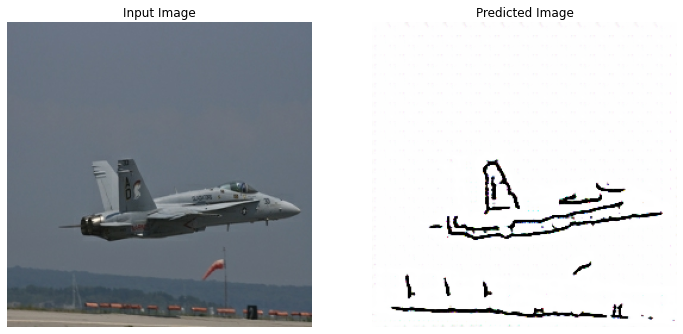

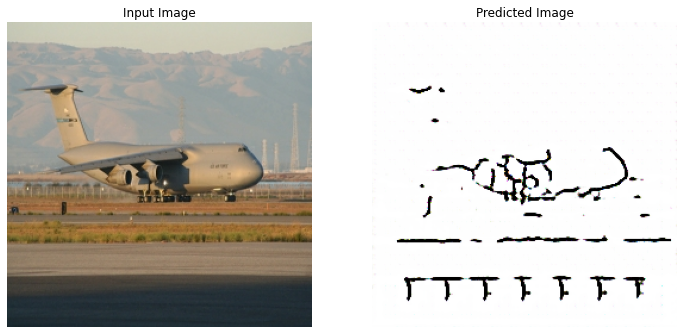

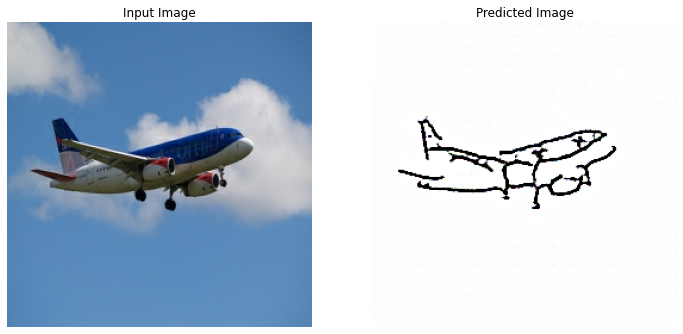

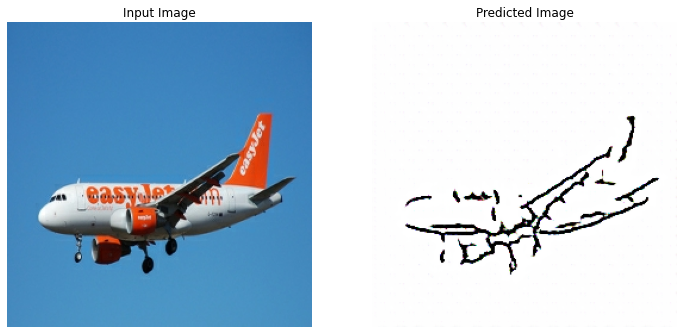

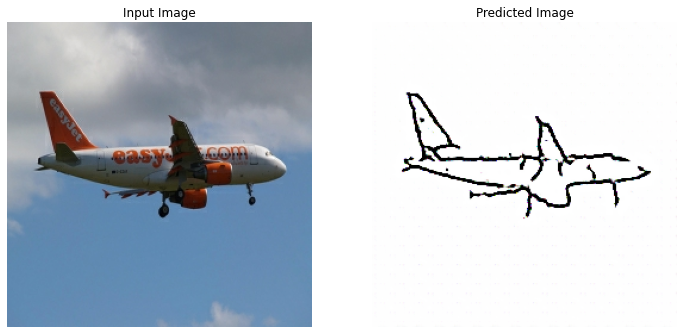

In [0]:
# Run the trained model on the test dataset
for inp in test_datasetA.take(5):
  generate_images(generator_g, inp)

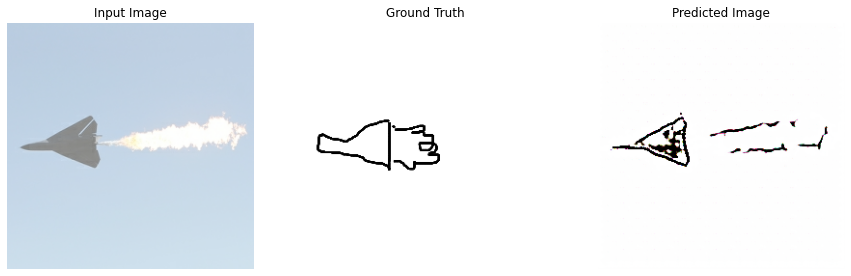

In [0]:
file_photo = os.path.join(dir_data, 'photo', 'tx_000000000000', 'airplane', 'n02691156_9966.jpg')
file_sketch = os.path.join(dir_data, 'sketch', 'tx_000000000000', 'airplane', 'n02691156_9966-1.png')
tf_dataset = tf.data.Dataset.list_files(file_photo)
tf_dataset = tf_dataset.map(
  read_image_data, num_parallel_calls=AUTOTUNE).cache().batch(1)

def read_sketch_data(file_path):
  tf_photo = tf.io.read_file(file_path)
  tf_photo = tf.io.decode_png(tf_photo)
  tf_photo = tf.image.convert_image_dtype(tf_photo, tf.float32)
  return tf_photo

tf_tar = tf.data.Dataset.list_files(file_sketch)
tf_tar = tf_tar.map(
  read_sketch_data, num_parallel_calls=AUTOTUNE).cache().batch(1)

for tf_photo in tf_dataset.take(1):
  for tar in tf_tar.take(1):
    generate_images(generator_g, tf_photo, tar=tar)


In [0]:
for inp in test_datasetA.take(1):
  prediction = generator_g(inp)
print(prediction)

tf.Tensor(
[[[[0.99991196 0.99984866 0.99994475]
   [0.99998486 0.9999983  0.9999967 ]
   [0.9999836  0.999951   0.99998736]
   ...
   [0.97720915 0.98521495 0.97521603]
   [0.99853724 0.9964593  0.9981809 ]
   [0.9866762  0.98571336 0.99248135]]

  [[0.9999854  0.9999932  0.9999947 ]
   [0.999999   0.99999815 0.99999887]
   [0.999998   0.99999464 0.99999833]
   ...
   [0.983161   0.9661766  0.985725  ]
   [0.9957889  0.9958105  0.997896  ]
   [0.9875486  0.99371976 0.9882275 ]]

  [[0.9997054  0.99984837 0.99978304]
   [0.99997675 0.9999731  0.9999757 ]
   [0.9998208  0.9994209  0.9999177 ]
   ...
   [0.99099845 0.98234963 0.97740674]
   [0.97404486 0.9712776  0.98471314]
   [0.95174074 0.9580732  0.94053787]]

  ...

  [[0.999958   0.9999711  0.99996996]
   [0.99998343 0.9999827  0.999976  ]
   [0.999898   0.9998798  0.9999122 ]
   ...
   [0.9999273  0.99996835 0.99993956]
   [0.99999976 0.9999998  0.9999998 ]
   [0.99998397 0.99999094 0.9999941 ]]

  [[0.9999906  0.9999874  0.999994

In [0]:
import skimage
import skimage.io
import skimage.filters
import re

In [0]:
def load(file_sketch):
  sketch = skimage.io.imread(file_sketch)
  
  file_photo = file_sketch.replace('/sketch/', '/photo/')
  file_photo = re.sub(r'-\d+\.png$', '.jpg', file_photo)
  photo = skimage.io.imread(file_photo)

  return photo, sketch

In [0]:
def read_image_data(file_path):
  tf_photo = tf.io.read_file(file_path)
  tf_photo = tf.io.decode_jpeg(tf_photo)
  tf_photo = tf.image.convert_image_dtype(tf_photo, tf.float32)
  return tf_photo

In [0]:
d = []
n_pix_edge = []
n_pix_sketch = []
for file_sketch in os.listdir(PATH_TEST_B):
  file_sketch = os.path.join(PATH_TEST_B, file_sketch)
  photo, sketch = load(file_sketch)
  file_photo = file_sketch.replace('/sketch/', '/photo/')
  file_photo = re.sub(r'-\d+\.png$', '.jpg', file_photo)
  

  tf_dataset = tf.data.Dataset.list_files(file_photo)
  tf_dataset = tf_dataset.map(
    read_image_data, num_parallel_calls=AUTOTUNE).cache().batch(1)

  for tf_photo in tf_dataset.take(1):
    prediction = generator_g(tf_photo)
    prediction = prediction[0].numpy()
    
    prediction = prediction.mean(axis=2) < 0.5
    # tmp = skimage.filters.sobel(skimage.color.rgb2gray(photo))
    # edges = tmp > skimage.filters.threshold_otsu(tmp)
    # d.append(np.sum(np.logical_xor(edges, prediction)))
    # n_pix_edge.append(edges.sum())
    n_pix_sketch.append(prediction.sum())

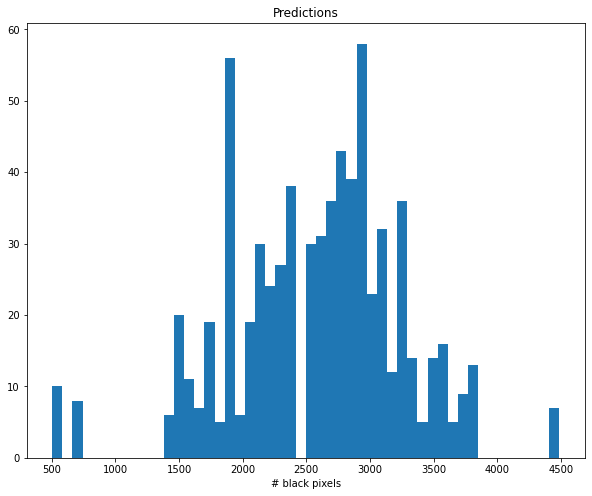

In [0]:
plt.figure(figsize=[10,8])
# axs[0].hist(n_pix_edge, bins=50)
# axs[0].set(xlabel='# black pixels', title='Edges')
plt.hist(n_pix_sketch, bins=50)
plt.xlabel('# black pixels')
plt.title('Predictions')
dir_results = os.path.join(dir_project, 'results')
plt.savefig(os.path.join(dir_results, 'n_black_pixels_cyclegan_predictions.png'))
plt.show()

## Next steps

This tutorial has shown how to implement CycleGAN starting from the generator and discriminator implemented in the [Pix2Pix](https://www.tensorflow.org/tutorials/generative/pix2pix) tutorial. As a next step, you could try using a different dataset from [TensorFlow Datasets](https://www.tensorflow.org/datasets/datasets#cycle_gan). 

You could also train for a larger number of epochs to improve the results, or you could implement the modified ResNet generator used in the [paper](https://arxiv.org/abs/1703.10593) instead of the U-Net generator used here.